## 4. Анализ результатов A/B-тестирования: кумулятивные метрики

Итак, давайте рассмотрим, как проводится анализ результатов A/B-тестирования (в нашем алгоритме он был обозначен под номером 6) с помощью Python.

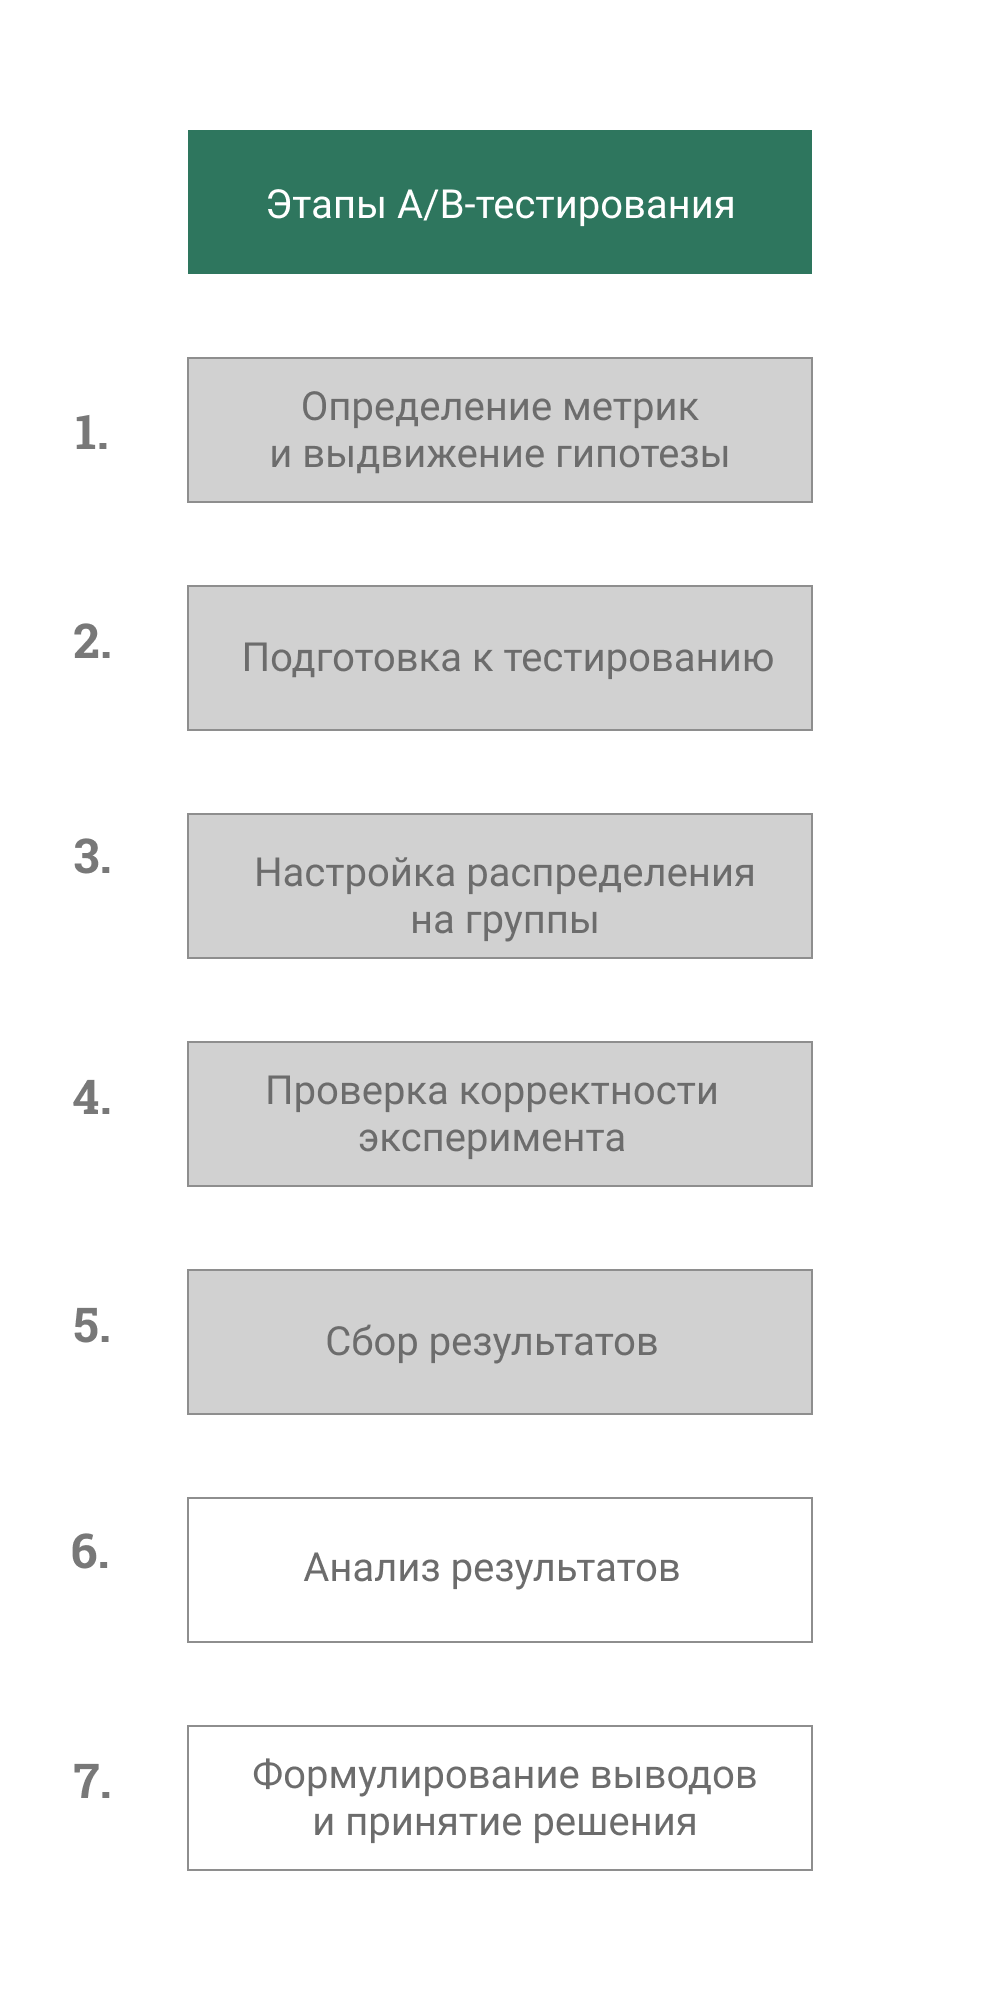



В качестве примера давайте попробуем решить задачу об анализе конверсии на некотором интернет-магазине, который занимается продажей различных товаров. Другие возможные задачи анализа результатов A/B-тестирования решаются похожим образом с учётом специфичности рассматриваемой метрики, длительности тестирования и характера распределения целевого показателя.

ОПИСАНИЕ ЗАДАЧИ

Проводится A/B-тестирование для двух вариантов рекомендаций сопутствующих товаров в профиле товара некоторого интернет-магазина. 

* Вариант 1. Дополнительные товары рекомендуются на основе статистических данных уже совершённых покупок — товары, которые другие пользователи часто покупают с основным. 

* Вариант 2. Дополнительные товары рекомендуются на основе совершённых пользователем ранее покупок с помощью рекомендательной системы, построенной на основе гибридного подхода.
Варианты сравниваются по доле пользователей, которые добавляют хотя бы один из предложенных товаров в корзину (метрикой является конверсия действия «добавить в корзину сопутствующий товар»).

Для этого пользователи были разделены на две группы. 

* Контрольной (группе А) доступен первый вариант рекомендаций.
* Тестовой (группе B) доступен второй вариант. 
  
Предполагается, что все условия и принципы проведения A/B-теста были соблюдены, то есть:

✔️ выборка имеет достаточный для принятия решения объём;

✔️ выбран достаточный интервал времени для тестирования;

✔️ группы максимально сбалансированы;

✔️ внешнее вмешательство минимально.

Итак, в результате проведения A/B-тестирования были получены следующие данные:

  [Скачать данные](https://lms-cdn.skillfactory.ru/assets/courseware/v1/f9f05ba6ecb36996a8ec5c6e89cd2a75/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/ab_data.zip)

На основании этих данных нам предстоит сделать вывод о том, какой из вариантов рекомендаций (А или B) является более эффективным по показателю конверсии.

ЗНАКОМИМСЯ С ДАННЫМИ

Прежде, чем переходить к этапу анализа, необходимо совершить некоторые преобразования над данными, для этого импортируем библиотеки, которые нам пригодятся:

In [631]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

Импортировав библиотеки, откроем в ноутбуке сохранённый в папке data датасет:

In [632]:
ab_data =pd.read_csv('C:\скил\DST-156\IDE_NEW\DS_PROD-4. AB-тестирование/ab_data.csv')


И выведем пять первых строк таблицы:

In [633]:
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


Итак, мы получили таблицу со следующими полями:

| Название поля |	Описание|
|---|---|
|user_id|	идентификатор пользователя, зашедшего на сайт|
|timestamp|	дата события|
|group|	группа теста (контрольная или тестовая)|
|converted	|совершил пользователь целевое действие (нажатие кнопки «добавить в корзину» на сопутствующем товаре) или нет. 1 — да, 0 — нет.|

Посмотрим тип данных и содержание каждого столбца, для этого применим к датафрейму метод info():

In [634]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


Итак, в наших данных нет пропусков, однако нам нужно перевести столбец с информацией о дате события (timestamp) в формат datetime. Напомним: для этого мы можем воспользоваться функцией pandas to_datetime():

In [635]:
ab_data['timestamp']= pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')

В итоге мы получили таблицу, в которой отображены входы клиента на сайт (сессия) и его действия. Для того, чтобы получить показатель конверсии в группах на каждый день, нам необходимо предварительно сгруппировать наши данные по дате и группе и вычислить количество пользователей, заходивших на сайт, и суммарное количество совершённых целевых действий. 

Дополнительно для удобства сбросим индекс на сгруппированной таблице c помощью метода [reset_index()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html) и переименуем столбец user_id в users_count с помощью метода [rename()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html).

In [636]:
daily_data=ab_data.groupby(['timestamp','group']).agg({'user_id':'count','converted':'sum'}).reset_index().rename(columns={'user_id':'users_count'})
daily_data.head(7)

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797
5,2017-01-04,B,6538,763
6,2017-01-05,A,6419,791


Примечание. Количество пользователей в день в контрольной и тестовой группе определяется как количество значений в столбце user_id в сгруппированных данных, а количество совершённых целевых действий — это просто сумма по столбцу converted (1 в строке означает положительный исход, то есть целевое действие было совершено, а 0 — отрицательный исход; просуммировав все 1 и 0 в группе, получим количество положительных исходов).




Для завершения этапа подготовки данных к анализу нам осталось рассчитать конверсию на каждый день проведения A/B-тестирования. Напомним: ежедневная конверсия рассчитывается как отношение числа посетителей сайта, выполнивших на нём какие-либо целевые действия в день, к ежедневному общему числу посетителей сайта, умноженная на 100 %:

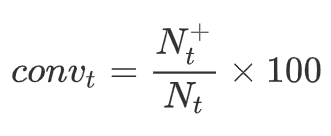

![alt text](image.png)


Задание 4.1

Рассчитайте конверсию на каждый день по приведённой формуле. Результат занесите в столбец conversion. Чему была равна конверсия (в процентах) в группе А 5 января 2017 года? Ответ округлите до второго знака после запятой.

In [637]:
daily_data['conversion']=daily_data['converted']/daily_data['users_count']*100

daily_data

mask=daily_data  [  (daily_data['timestamp']=='2017-01-05') & 
             (daily_data['group']=='A')   ]  ['conversion']
print(round (mask,2))

6    12.32
Name: conversion, dtype: float64


Возможный вариант решения:
```
daily_data['conversion'] = daily_data['converted']/daily_data['users_count'] * 100
print(round(daily_data[
    (daily_data['timestamp'] == '2017-01-05') & (daily_data['group'] == 'A')
]['conversion'], 2))
display(daily_data.head())
```



Вычислив ежедневную конверсию, мы получим следующую таблицу:

In [638]:
display(daily_data.head())

,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063
3,2017-01-03,B,6620,754,11.389728
4,2017-01-04,A,6573,797,12.125361


ВИЗУАЛЬНЫЙ АНАЛИЗ КОНВЕРСИИ В ГРУППАХ

Нам необходимо ответить на вопрос: в какой группе (А или B) показатель конверсии был выше, и на этой основе принять решение о том, какой из вариантов более эффективный. 

Давайте построим диаграмму boxplot для сравнения параметров распределения ежедневной конверсии по группам. 

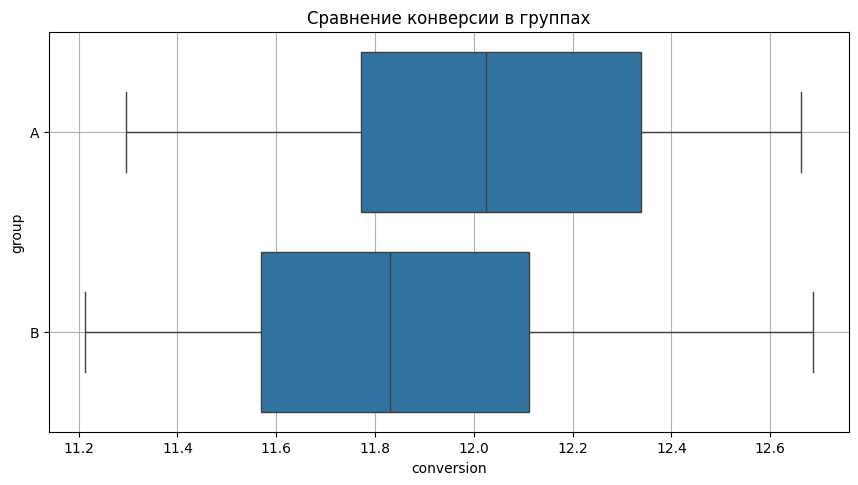

In [639]:
# создаём фигуру размером 8x4
fig=plt.figure(figsize=(8,4))
# добавляем систему координат
ax=fig.add_axes([1,1,1,1])
# строим boxplot для conversion по признаку group
sns.boxplot(data=daily_data,x='conversion', y='group', ax=ax)
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid(True)

**Что можно сказать исходя из этого графика?** Во-первых, медианное значение ежедневной конверсии в группе А, выше, чем в группе B. Во-вторых, разброс конверсии в группе B несколько больше, чем в группе A.

Тут неопытный специалист воскликнет: версия рекомендаций А лучше, чем версия B (медиана конверсии варианта А больше, да и разброс поменьше, то есть конверсия более стабильна) — и завершит эксперимент. 

Но выводы делать ещё рано! И сейчас попробуем понять, почему. 

**Примечание.** Прежде чем делать выводы по визуальному представлению данных, всегда обращайте внимание на численные значения показателей. Они могут различаться в масштабе графика, но на практике разница между ними не будет иметь значения. Также всегда стоит убедиться, что в данных нет выбросов (базовый вариант — сравнить медиану и среднее между собой). Далее мы ещё поговорим о стабилизации показателя во времени.

Давайте вычислим средний и медианный показатель конверсии в контрольной и тестовой группе и умножим результат на 100 (получим результат в процентах):

In [640]:
conversion_piv=daily_data.groupby('group')['conversion'].agg(['mean','median'])
conversion_piv

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


Возникает вопрос: а значима ли вообще такая разница в показателях или она обусловлена случайностью, и варианты A и B одинаково эффективны по метрике конверсии?

Прежде чем отвечать на этот вопрос, нам нужен ответ на другой вопрос: а стабилен ли показатель конверсии в группах во времени или он колеблется как «уж на сковородке»? 

**Примечание.** Вопрос о стабильности метрик является обязательным. Прогонять результаты через статистические тесты можно только после того, как вы убедитесь, что разница в ваших показателях стабилизировалась во времени. Это связано с проблемой подглядывания, речь о которой пойдёт ниже.

Тут нам помогут кумулятивные метрики.

**КУМУЛЯТИВНЫЕ МЕТРИКИ**

В течение всего теста рекомендуется отслеживать поведение целевых метрик. Для этого чаще всего используются кумулятивные метрики.

**Кумулятивная метрика** — это отображение целевой метрики, когда вы отслеживаете её поведение за каждый день — накопленным итогом по дням. 

**Почему это важно?**

Ранее мы говорили, что для принятия решения в A/B-тестировании требуется большой объём данных, что соотносится с законом больших чисел: чем больше данных — тем ближе получаемый результат к математическому ожиданию (истинному среднему). 

Вспомните пример про подбрасывание монетки. Если подбросить монетку 10 раз, то велика вероятность, что один из двух результатов будет значительно превышать второй. Но если подбросить её 1 000 раз, то результаты компенсируют друг друга, и мы увидим, что итог крайне близок к разделению 50/50 (количество выпавших орлов и решек будет практически одинаковым).

Так же и в A/B-тестировании: с самого начала любой из вариантов может показывать лучшие результаты, и статистическая значимость может быть достигнута уже в первые дни теста. Это явление называется **проблемой подглядывания**.

**Важно!** Не стоит торопиться: как минимум дождитесь накопления запланированных объёмов выборки и длительности теста. Но и тут не стоит заканчивать тест — проверьте, стабилизировались ли метрики!

То есть в начале теста любой полученный за день результат будет оказывать сильное влияние на результат теста. Но со временем данные будут накапливаться, и доля получаемых за день данных будет всё меньше и меньше воздействовать на уже накопленный результат. 

Кумулятивный график конверсии может выглядеть, например, так: 

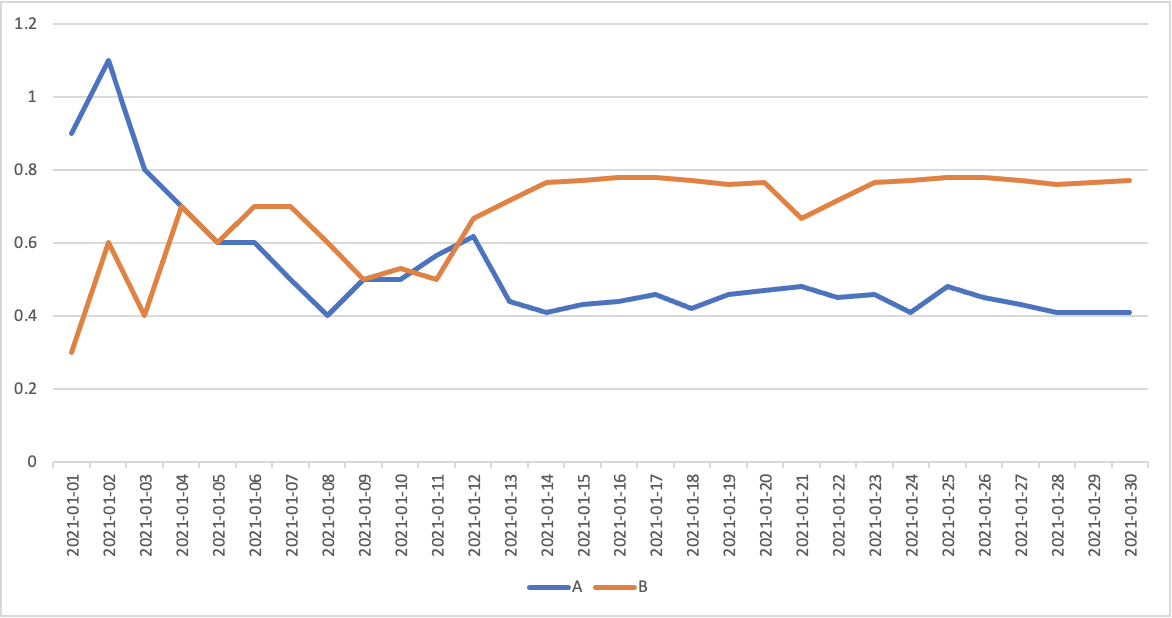

Как видите, в начале данные подвержены сильному колебанию, но со временем они выравниваются.

**Примечание.** Кумулятивная метрика считается стабилизированной, когда на графике прекращаются резкие пики и спады показателя, и линия постепенно выравнивается в горизонтальную прямую.

### Важно! Принимать какие-либо решения стоит только после того, как метрика стабилизируется!

Согласно центральной предельной теореме и закону больших чисел, с увеличением объёма данных метрика стабилизируется и будет стремиться к реальному среднему. 

Примечание. В качестве кумулятивной метрики можно считать не только конверсию, но и выручку, средний чек, количество заказов, процент негативных комментариев, точность модели и так далее.

Итак, давайте применим новые знания к нашим данным и вычислим кумулятивную конверсию, а затем построим её график. 

Но для начала ради эксперимента посмотрим, как вообще изменялись показатели ежедневной конверсии в каждой группе во времени. Для этого построим линейные графики для каждой группы: по оси абсцисс отложим дату, а по оси ординат — показатель конверсии:

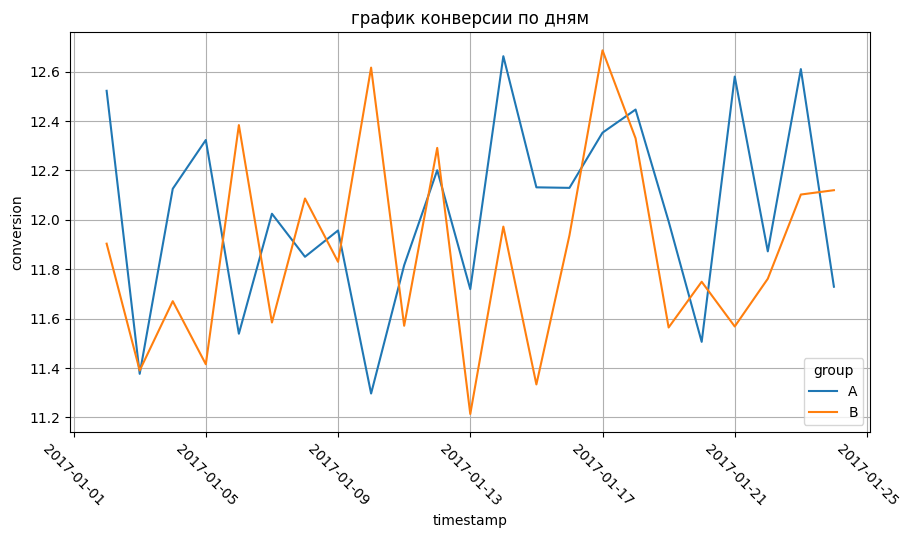

In [641]:
# создвем фигуру размером 8*4
fig=plt.figure(figsize=(8,4))
# добавляем систему координат
ax=fig.add_axes([1,1,1,1])
# строим lineplot для конверсии во времени для каждой группы
sns.lineplot(data=daily_data,
             x='timestamp',
             y='conversion',
             hue='group',
             ax=ax)
# задаем подпись к графику
ax.set_title('график конверсии по дням')
# задаем поворгот меток по оси абсцисс
ax.xaxis.set_tick_params(rotation=-45)
# задаем отображение сетки
ax.grid(True)

**Что можно сказать по такому графику?** Да практически ничего! Конверсия у обеих групп «скачет» день ото дня. Понять, какая из групп лучше, — практически невыполнимая задача. 

Именно поэтому и принято смотреть график кумулятивной конверсии, где за каждый день отображаются данные накопленным итогом.

Для расчёта кумулятивного показателя суммы в Pandas есть специальный метод [cumsum()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cumsum.html). Давайте посмотрим, как он работает — сначала на данных о ежедневном количестве посетителей для группы А. 

Выберем данные для группы А и создадим в полученной таблице новый столбец *cum_users_count*, в который запишем результат работы метода *cumsum()* по столбцу *users_count*:

In [642]:
# выделяем данные группы А
daily_data_a=daily_data[daily_data['group']=='A']
daily_data_a
# считаем кумулятивное колличество посетителей
daily_data_a.loc[:,'cum_users_count']=daily_data_a['users_count'].cumsum()
# выводим время, количество посетителей и кумулятивное количество посетителей
display(daily_data_a[['timestamp','users_count','cum_users_count']])

C:\Users\molde\AppData\Local\Temp\ipykernel_32120\3373891934.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data_a.loc[:,'cum_users_count']=daily_data_a['users_count'].cumsum()


,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031
10,2017-01-07,6595,35626
12,2017-01-08,6692,42318
14,2017-01-09,6624,48942
16,2017-01-10,6657,55599
18,2017-01-11,6686,62285


Обратите внимание, что в столбце с кумулятивной суммой за 2017-01-03 указано 9 435 пользователей. Сложите данные за 2017-01-02 и 2017-02-03 из столбца users_count — получите те же 9 435. Аналогично и для других дней. 

То есть кумулятивная сумма — это накопительная сумма; каждое её значение — это результат сложения показателя за предыдущие дни с показателем за текущий день. 

Кумулятивную сумму можно записать в виде рекурсивной формулы:

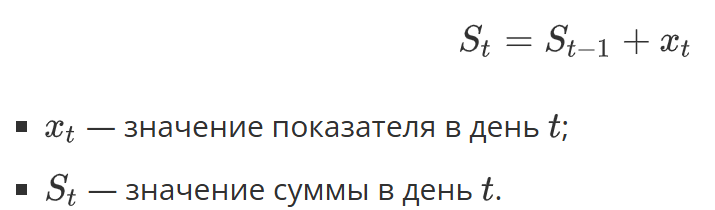

?Как сделать такой расчёт для двух групп (А и B) сразу? Воспользуемся методом `groupby`: сгруппируем данные по признаку группы, и в каждой группе будем вычислять кумулятивные суммы признаков количества посетителей (users_count) и количества совершённых целевых действий (converted). 

После этого рассчитаем **кумулятивную** конверсию — это отношение ежедневной кумулятивной суммы количества посетителей к ежедневной кумулятивной сумме количества совершённых целевых действий:

In [643]:
daily_data.head()

,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063
3,2017-01-03,B,6620,754,11.389728
4,2017-01-04,A,6573,797,12.125361


In [644]:
# вчисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count']=daily_data.groupby(['group'])['users_count'].cumsum()
daily_data.head()
# вычисляем кумулятивную сумму количества совершенных целевых действий
daily_data['cum_converted']=daily_data.groupby(['group'])['converted'].cumsum()
daily_data.head()
# вычисляем кумулятивную конвверсию

daily_data['cum_conversion']=daily_data['cum_converted']/daily_data['cum_users_count']*100
daily_data.head()


,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


А теперь построим графики кумулятивной конверсии по дням в каждой группе:

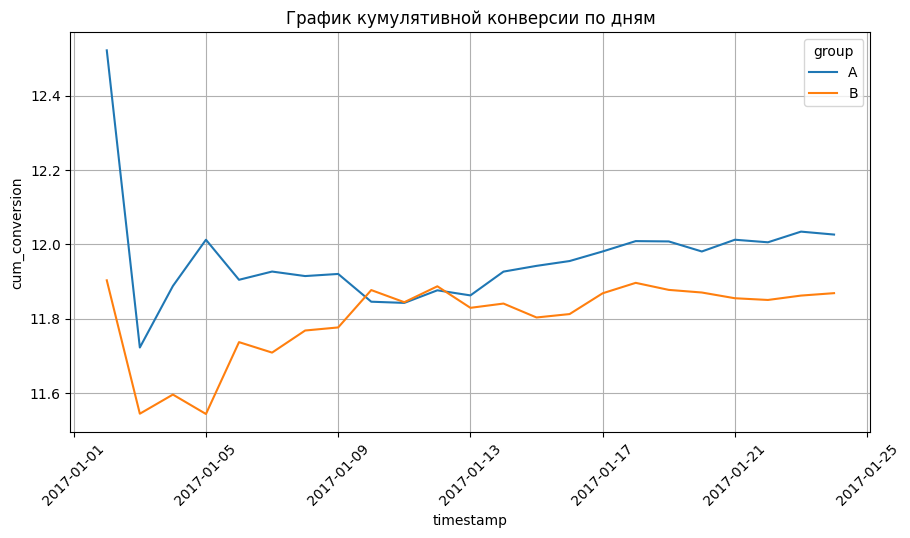

In [645]:
# создаем фигуру размером 8х4
fig=plt.figure(figsize=(8,4))
#добавляем систему координат
ax=fig.add_axes([1,1,1,1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='cum_conversion',
    hue='group',
    ax=ax
)
# задаем подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаем поворот меток
ax.xaxis.set_tick_params(rotation=45)
# задаем отображение сетки
ax.grid(True)

**Что можно сказать теперь?** До 2017-01-09 конверсия была нестабильна, но после 2017-01-11 резкие скачки прекратились (кривая графика переходит в прямую). Судя по графику, конверсия группы B стабильно хуже конверсии группы А на всём промежутке времени. 

Обратите внимание на различие в конверсии в первые дни теста: тут наглядно отображена проблема подглядывания, когда статистическая значимость ошибочно могла быть достигнута уже в самом начале теста.

На основании стабилизированного кумулятивного графика мы можем сделать вывод, что длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателем конверсии в группах.

⭐️ Значит, мы можем переходить к проведению статистических тестов. Но прежде предлагаем решить несколько заданий.

Задание 4.2

Почему при проведении анализа результатов A/B-тестирования нельзя делать выводы, основываясь только на визуальном анализе и вычисленных показателях в группах?

- [ ] визуальный анализ всегда «врёт»
- [X] разница между метриками в группах может оказаться статистически незначимой = TRUE
- [ ] визуальный анализ не даёт представления о разнице между показателями в группах

Задание 4.3

Зачем нужны кумулятивные метрики?

- [ ] они помогают увидеть распределение метрики в каждой группе
- [X] они помогают ответить на вопрос о стабилизации метрик во времени =TRUE
- [ ] они помогают определить статистическую значимость результатов в каждой группе
- [ ] они помогают определить размер выборки, необходимой для тестирования

Задание 4.4

Что такое проблема подглядывания?

- [X] ошибочное принятие решения о статистической значимости результатов до ожидания окончания статистического теста = TRUE
- [ ] предсказание конечных результатов теста с помощью модели машинного обучения
- [ ] несбалансированность групп для тестирования
- [ ] запуск теста без предварительного определения гипотезы и метрик

Задание 4.5

С помощью какого метода Pandas можно вычислить кумулятивную сумму по столбцу?

- [ ] cumcount()
- [ ] cummean()
- [ ] sum()
- [X] cumsum()= TRUE
нет ответа
Отправить

**Вводные данные для задач 4.6–4.9**

Проводится A/B-тестирование для двух вариантов дизайна сайта. Результаты тестирования собраны в двух файлах (данные для группы А и для группы B).

[→ Данные по группе А](https://lms-cdn.skillfactory.ru/assets/courseware/v1/c3bcdf8e84ea8fc45d08fe987299dea2/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/ab_test-redesign_sample_a.zip)

[→ Данные по группе B](https://lms-cdn.skillfactory.ru/assets/courseware/v1/91524f30dbacb1a751a1d4a935b8f7bb/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/ab_test-redesign_sample_b.zip)

In [646]:
sample_a = pd.read_csv('C:\скил\DST-156\IDE_NEW\DS_PROD-4. AB-тестирование/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('C:\скил\DST-156\IDE_NEW\DS_PROD-4. AB-тестирование/ab_test-redesign_sample_b.csv')
display(sample_a.head(3), sample_b.head(3))

,date,cid,transactions,revenue,group
0,2020-11-06,1.001648e+09,0,0,A
1,2020-11-06,1.001936e+09,0,0,A
2,2020-11-06,1.003214e+08,0,0,A


,date,cid,transactions,revenue,group
0,2020-11-06,1.000135e+09,0,0,B
1,2020-11-06,1.001648e+09,0,0,B
2,2020-11-06,1.003214e+08,0,0,B



Каждая таблица имеет следующие поля:

* date — дата наблюдения;
* cid — идентификатор посетителя;
* transactions — количество совершённых целевых действий (транзакций);
* revenue — сумма покупки;
* group — группа (тестовая — А, контрольная — B).
  
Используйте эти данные для ответа на следующие вопросы.

Задание 4.6

Постройте таблицу со следующими ежедневными показателями:

* количество посетителей сайта;
* суммарное число транзакций;
* общая сумма покупок (выручка).
  
Для этого сгруппируйте данные по признаку date, предварительно преобразовав его к типу datetime.

In [647]:
sample_a['date']=pd.to_datetime(sample_a['date'],format='%Y-%m-%d')
sample_b['date']=pd.to_datetime(sample_b['date'],format='%Y-%m-%d')


In [648]:
sample_a_date=sample_a.groupby('date').agg({
    'cid':'count',
    'transactions':'sum',
    'revenue':'sum'}).reset_index()
#sample_a_date
sample_b_date=sample_b.groupby('date').agg({
    'cid':'count',
    'transactions':'sum',
    'revenue':'sum'}).reset_index()
#sample_b_date
sample_a_date[sample_a_date['date'] == '2020-11-08']

,date,cid,transactions,revenue
2,2020-11-08,3354,25,846051


Чему равны значения ежедневных показателей в группе А на 8 ноября 2020 года?

Количество посетителей сайта:

  нет ответа = 3354
 
Суммарное число транзакций:

  нет ответа =25
 
Общая сумма покупок:

  нет ответа =846051

Задание 4.7

Добавьте в каждую из таблиц кумулятивные метрики:

* кумулятивное количество посетителей сайта;
* кумулятивное суммарное число транзакций;
* кумулятивная общая сумма покупок (кумулятивная выручка).
  
Рассчитайте кумулятивную конверсию действия покупки ('conversion_cum'= транзакции делим на покупателей)(в процентах) и кумулятивный средний чек (кумулятивная выручка/кумулятивное суммарное число транзакций).

In [649]:
sample_a_date['cid_count_cum']= sample_a_date['cid'].cumsum()
sample_b_date['cid_count_cum']= sample_b_date['cid'].cumsum()
sample_a_date['transactions_cum']= sample_a_date['transactions'].cumsum()
sample_b_date['transactions_cum']= sample_b_date['transactions'].cumsum()
sample_a_date['revenue_cum']= sample_a_date['revenue'].cumsum()
sample_b_date['revenue_cum']= sample_b_date['revenue'].cumsum()
sample_a_date['conversion_cum']=sample_a_date['transactions_cum']/sample_a_date['cid_count_cum']*100
sample_b_date['conversion_cum']=sample_b_date['transactions_cum']/sample_b_date['cid_count_cum']*100
sample_a_date['mean_check_cum']=sample_a_date['revenue_cum']/sample_a_date['transactions_cum']
sample_b_date['mean_check_cum']=sample_b_date['revenue_cum']/sample_b_date['transactions_cum']

In [650]:
sample_a_date.head(10)

,date,cid,transactions,revenue,cid_count_cum,transactions_cum,revenue_cum,conversion_cum,mean_check_cum
0,2020-11-06,2576,16,1577279,2576,16,1577279,0.621118,98579.937500
1,2020-11-07,2704,23,1721886,5280,39,3299165,0.738636,84593.974359
2,2020-11-08,3354,25,846051,8634,64,4145216,0.741256,64769.000000
3,2020-11-09,3234,18,708830,11868,82,4854046,0.690934,59195.682927
4,2020-11-10,3022,29,826984,14890,111,5681030,0.745467,51180.450450
5,2020-11-11,3218,19,1209656,18108,130,6890686,0.717915,53005.276923
6,2020-11-12,3467,19,607839,21575,149,7498525,0.690614,50325.671141
7,2020-11-13,3676,36,1338816,25251,185,8837341,0.732644,47769.410811
8,2020-11-14,3372,30,2659277,28623,215,11496618,0.751144,53472.641860
9,2020-11-15,3881,27,1189970,32504,242,12686588,0.744524,52423.917355


Чему равна средняя кумулятивная конверсия в группах за весь период проведения A/B-теста? Ответ округлите до сотых, знаки процентов не вводите.

  нет ответа =0.71
  нет ответа =0.76

In [651]:
conversion_a_mean=sample_a_date['conversion_cum'].mean()
conversion_b_mean=sample_b_date['conversion_cum'].mean()
print(round(conversion_a_mean,2))
print(round(conversion_b_mean,2))

0.71
0.76


Эталонное решение:
```
# объявляем функцию для расчёта кумулятивных показателей
def calculate_cum(data):
    data['cum_users_count'] = data['cid'].cumsum()
    data['cum_transactions'] = data['transactions'].cumsum()
    data['cum_revenue'] = data['revenue'].cumsum()
    data['cum_conversion'] = data['cum_transactions']/data['cum_users_count'] * 100
    data['cum_mean_check'] = data['cum_revenue']/data['cum_transactions']
    return data
# применяем функцию для каждого набора данных:
daily_sample_a = calculate_cum(daily_sample_a)
daily_sample_b = calculate_cum(daily_sample_b)
# вычислим среднюю кумулятивную конверсию в каждой группе
print(round(daily_sample_a['cum_conversion'].mean(), 2))
print(round(daily_sample_b['cum_conversion'].mean(), 2))
```

Задание 4.8

Постройте графики кумулятивной конверсии в каждой группе. Какие выводы по ним вы можете сделать?


- [ ] Конверсия в группе B стабильно выше конверсии в группе A на всём промежутке времени.
- [ ] С уверенностью можно сказать, что, если продолжить тест, конверсия в группе A будет выше конверсии в группе B.
- [X] Начиная с 9 ноября 2020 года конверсии в группах имеют приблизительно идентичное поведение (одинаковые точки роста и спада). При этом конверсия в группе B стабильно выше конверсии в группе A на данном периоде. = TRUE
- [ ] Никаких выводов сделать нельзя.
нет ответа

In [652]:
sample_a_date.head(3)

,date,cid,transactions,revenue,cid_count_cum,transactions_cum,revenue_cum,conversion_cum,mean_check_cum
0,2020-11-06,2576,16,1577279,2576,16,1577279,0.621118,98579.937500
1,2020-11-07,2704,23,1721886,5280,39,3299165,0.738636,84593.974359
2,2020-11-08,3354,25,846051,8634,64,4145216,0.741256,64769.000000


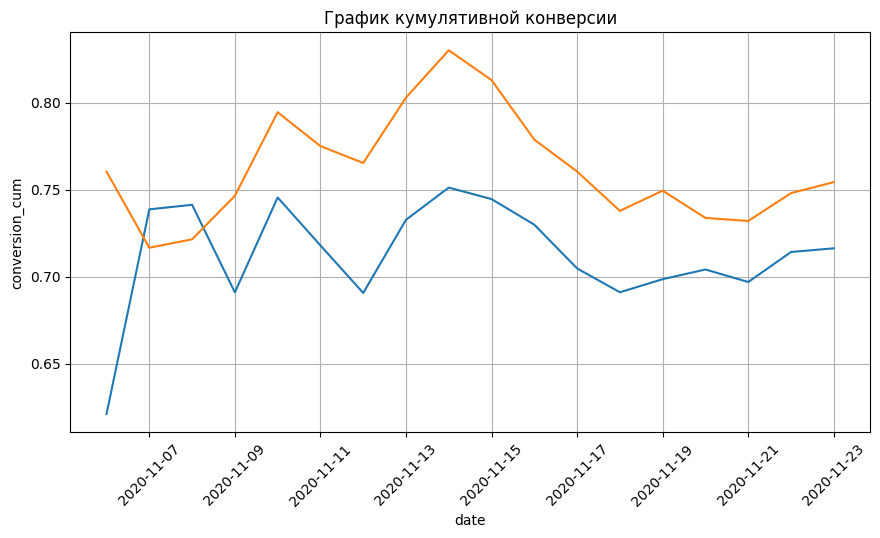

In [653]:
fig_4_8=plt.figure(figsize=(8,4))
ax_4_8= fig_4_8.add_axes([1,1,1,1])
sns.lineplot(
    data=sample_a_date,
    x='date',
    y='conversion_cum',
    ax=ax_4_8
)
sns.lineplot(
    data=sample_b_date,
    x='date',
    y='conversion_cum',
    ax=ax_4_8
)
ax_4_8.set_title('График кумулятивной конверсии')
ax_4_8.xaxis.set_tick_params(rotation=45)
ax_4_8.grid(True)

Задание 4.9

Постройте графики кумулятивного среднего чека в каждой группе. Какие выводы по ним вы можете сделать?


- [ ] Средний чек в группе B стабильно выше среднего чека в группе A на всём промежутке времени.
- [ ] В начале периода наблюдения средний чек в группе B был меньше, чем средний чек в группе A. Однако при стабилизации метрик наблюдается обратный результат.
- [ ] В начале периода наблюдения средний чек в группе A был меньше, чем средний чек в группе B. Однако при стабилизации метрик наблюдается обратный результат.
- [ ] Никаких выводов сделать нельзя.
нет ответа

In [654]:
sample_a_date.head(3)

,date,cid,transactions,revenue,cid_count_cum,transactions_cum,revenue_cum,conversion_cum,mean_check_cum
0,2020-11-06,2576,16,1577279,2576,16,1577279,0.621118,98579.937500
1,2020-11-07,2704,23,1721886,5280,39,3299165,0.738636,84593.974359
2,2020-11-08,3354,25,846051,8634,64,4145216,0.741256,64769.000000


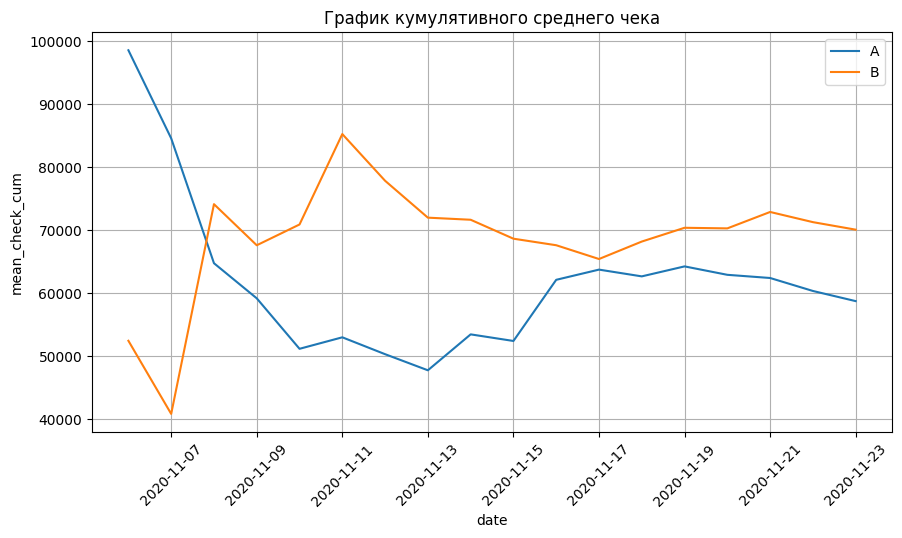

In [655]:
fig_4_9=plt.figure(figsize=(8,4))
ax_4_9=fig_4_9.add_axes([1,1,1,1])
sns.lineplot(
    data=sample_a_date,
    x='date',
    y='mean_check_cum',
    ax=ax_4_9,
    label='A'
)
sns.lineplot(
    data=sample_b_date,
    x='date',
    y='mean_check_cum',
    ax=ax_4_9,
    label='B'
)
ax_4_9.set_title('График кумулятивного среднего чека')
ax_4_9.xaxis.set_tick_params(rotation=45)
ax_4_9.grid(True)

# 5. Анализ результатов A/B-тестирования: статистические тесты

In [656]:
converted_piv=ab_data.groupby('group')['converted'].agg(['sum','count'])
converted_piv

,sum,count
group,,
A,17467,145241
B,17238,145241


In [657]:
from statsmodels.stats.proportion import proportions_ztest

In [658]:
alpha=0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_,p_value=proportions_ztest(
    count=converted_piv['sum'], #число «успехов»
    nobs=converted_piv['count'],#общее число наблюдений
    alternative='two-sided'
)
print('p-value:', round(p_value,3))# выводим результат на экран
if (p_value<=alpha):# сравниваем полученное p-value с уровнем значимости
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print('У нас нет оснований отвергнуть нулевую гипотезу')

p-value: 0.19
У нас нет оснований отвергнуть нулевую гипотезу


In [659]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для Z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], # число «успехов»
    nobs=converted_piv['count'], # общее число наблюдений
    alternative='larger' # правосторонняя альтернативная гипотеза
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

# p-value:  0.095
# У нас нет оснований отвергнуть нулевую гипотезу

p-value:  0.095
У нас нет оснований отвергнуть нулевую гипотезу


In [660]:
from statsmodels.stats.proportion import proportions_chisquare

In [661]:
alpha=0.05
_,p_value,c=proportions_chisquare(
    count=converted_piv['sum'],
    nobs=converted_piv['count']
)
print('p-value:',round(p_value,3))
if (p_value<=alpha):
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print('У нас нет оснований отвергнуть нулевую гипотезу')

p-value: 0.19
У нас нет оснований отвергнуть нулевую гипотезу


In [662]:
time_data=pd.read_excel('C:\скил\DST-156\IDE_NEW\DS_PROD-4. AB-тестирование/time_data.xlsx')
time_data.head(3)

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2


In [663]:
time_data[['time(A)','time(B)']].agg(['mean','median'])

,time(A),time(B)
mean,492.90,595.406667
median,482.25,600.400000


Text(0.5, 1.0, 'Распределение времени на сайте в группе B')

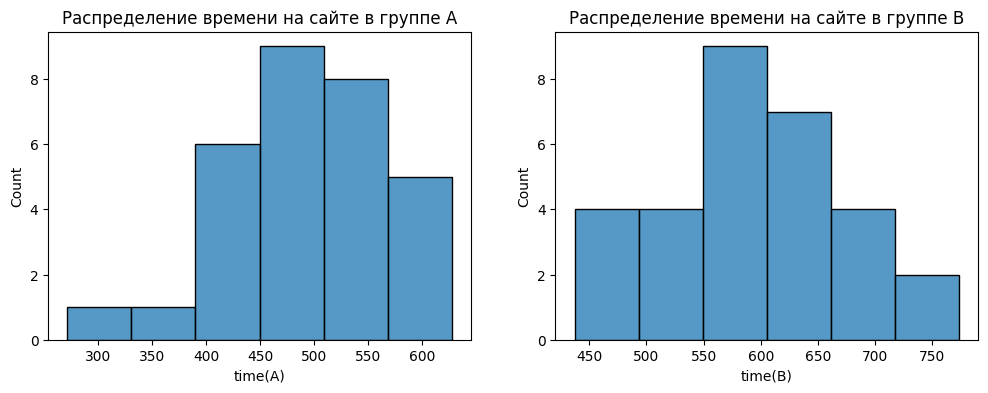

In [664]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
sns.histplot(data=time_data,x='time(A)',ax=axes[0])
sns.histplot(data=time_data, x='time(B)',ax=axes[1])
axes[0].set_title('Распределение времени на сайте в группе А')
axes[1].set_title('Распределение времени на сайте в группе B')

In [665]:
from scipy.stats import shapiro

In [666]:
alpha=0.05
shapiro_result_a=shapiro(time_data['time(A)'])
shapiro_result_b=shapiro(time_data['time(B)'])
print('p-value группы А', round (shapiro_result_a.pvalue,2))
print('p-value группы B', round (shapiro_result_b.pvalue,2))
if shapiro_result_a.pvalue<=alpha:
    print('Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального')
else:
    print('Принимаем нудевую гипотезу. Распределение в группе А является нормальным')    
if shapiro_result_b.pvalue<=alpha:
    print('Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального')
else:
    print('Принимаем нудевую гипотезу. Распределение в группе B является нормальным')    

p-value группы А 0.43
p-value группы B 0.12
Принимаем нудевую гипотезу. Распределение в группе А является нормальным
Принимаем нудевую гипотезу. Распределение в группе B является нормальным


In [667]:
from scipy.stats import ttest_ind

In [668]:
alpha=0.05
results=ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'],
    alternative='two-sided'
)
print('p-value:', round(results.pvalue,2))
if results.pvalue<=alpha:
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print('У нас нет оснований отвергнуть нулевую гипотезу')

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


In [669]:
check_data=pd.read_excel('C:\скил\DST-156\IDE_NEW\DS_PROD-4. AB-тестирование/check_data.xlsx')
check_data.head(3)

,date,mean_check_a,mean_check_b
0,2020-11-06,68701.239649,88665.123322
1,2020-11-07,26136.309375,46230.394893
2,2020-11-08,119470.770656,139356.451490


In [670]:
check_data[['mean_check_a','mean_check_b']].agg(['mean','median'])

,mean_check_a,mean_check_b
mean,76684.763071,96658.897304
median,62883.707793,82854.201467


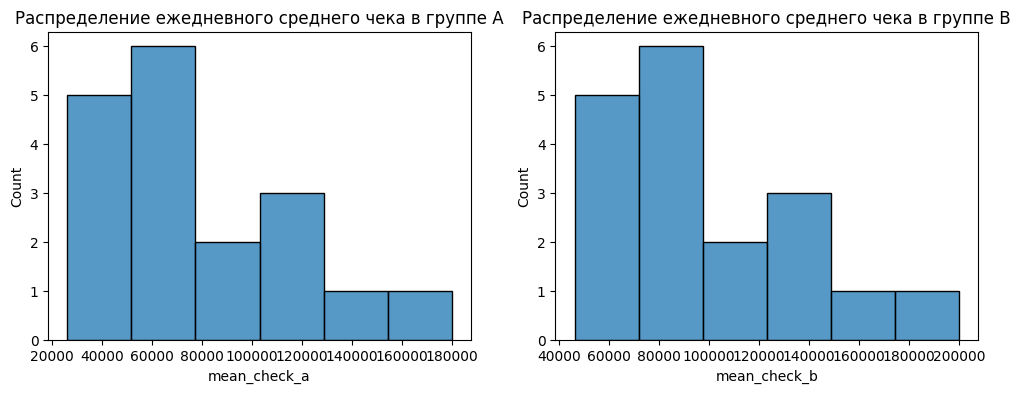

In [671]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
sns.histplot(data=check_data,x='mean_check_a',ax=axes[0])
sns.histplot(data=check_data, x='mean_check_b',ax=axes[1])
axes[0].set_title('Распределение ежедневного среднего чека в группе А')
axes[1].set_title('Распределение ежедневного среднего чека в группе B')
ax.xaxis.set_tick_params(rotation=45)
ax.grid(True)

In [672]:
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро — Уилка для выборок
shapiro_result_a = shapiro(check_data['mean_check_a'])
shapiro_result_b = shapiro(check_data['mean_check_b'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value для группы А с уровнем значимости
if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

# сравниваем полученное p-value для группы B с уровнем значимости
if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе B является нормальным")

p-value группы А 0.05
p-value группы B 0.05
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального


In [673]:
from scipy.stats import mannwhitneyu

In [674]:
alpha=0.05
results= mannwhitneyu(
    x=check_data['mean_check_a'],
    y=check_data['mean_check_b'],
    alternative='two-sided'
)
print('p-value:',round(results.pvalue,2))
if results.pvalue <= alpha:
    print('отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print('у нас нет оснований отвергнуть нулевую гипотезу')

p-value: 0.06
у нас нет оснований отвергнуть нулевую гипотезу


In [675]:
alpha=0.05
results= mannwhitneyu(
    x=check_data['mean_check_a'],
    y=check_data['mean_check_b'],
    alternative='less'
)
print('p-value:',round(results.pvalue,2))
if results.pvalue <= alpha:
    print('отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print('у нас нет оснований отвергнуть нулевую гипотезу')

p-value: 0.03
отвергаем нулевую гипотезу в пользу альтернативной


Задание 5.1

Проводится A/B-тестирование нового варианта расстановки товаров в магазине. Предполагается, что число покупок определённого товара вырастет, если расположить его рядом с кассой. Какой статистический тест вы будете использовать для сравнения вариантов расстановки по конверсии покупки этого товара?


- [ ] Z-тест для пропорций = true
- [ ] T-тест
- [ ] Тест Шапиро-Уилка
- [ ] ANOVA-тест

Для решения следующих заданий используйте наборы данных sample_a и sample_b из предыдущего юнита (перед заданием 4.6), где приведены результаты A/B-тестирования двух вариантов дизайна одного и того же сайта.

sample_a = pd.read_csv('data/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.csv')

# преобразуем тип столбца date к типу datetime
sample_a['date'] = pd.to_datetime(sample_a['date'])
sample_b['date'] = pd.to_datetime(sample_b['date'])

In [676]:
sample_a = pd.read_csv('C:\скил\DST-156\IDE_NEW\DS_PROD-4. AB-тестирование/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('C:\скил\DST-156\IDE_NEW\DS_PROD-4. AB-тестирование/ab_test-redesign_sample_b.csv')

# преобразуем тип столбца date к типу datetime
sample_a['date'] = pd.to_datetime(sample_a['date'])
sample_b['date'] = pd.to_datetime(sample_b['date'])

Задание 5.2

С помощью Z-теста для пропорций проанализируйте результаты проведённого A/B-тестирования и определите, какой из вариантов дизайна (A или B) более предпочтителен по метрике конверсии. В качестве уровня значимости возьмите . Используйте функцию proportions_ztest() из модуля statsmodels.stats.proportion.

Какой вывод можно сделать на основании результатов тестирования?


- [ ] Вариант A более предпочтителен, чем вариант B, по метрике конверсии.
- [ ] Вариант A менее предпочтителен, чем вариант B, по метрике конверсии.
- [ ] Варианты A и B равнозначны по метрике конверсии.=true
- [ ] Нельзя сделать однозначный вывод.

In [677]:
sample_a.head(3)

,date,cid,transactions,revenue,group
0,2020-11-06,1.001648e+09,0,0,A
1,2020-11-06,1.001936e+09,0,0,A
2,2020-11-06,1.003214e+08,0,0,A


In [678]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=[sample_a['transactions'].sum(),sample_b['transactions'].sum()], #число «успехов»
    nobs=[sample_a['cid'].sum(),sample_b['cid'].sum()], #общее число наблюдений
    alternative='two-sided',
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

# p-value:  0.19
# У нас нет оснований отвергнуть нулевую гипотезу

p-value:  0.432
У нас нет оснований отвергнуть нулевую гипотезу


Давайте вычислим ежедневный средний чек — это ежедневная сумма заказов, делённая на ежедневную сумму транзакций:

In [679]:
daily_sample_a = sample_a.groupby('date')[['transactions', 'revenue']].sum()
daily_sample_a['mean_check'] = daily_sample_a['revenue']/daily_sample_a['transactions']
daily_sample_b = sample_b.groupby('date')[['transactions', 'revenue']].sum()
daily_sample_b['mean_check'] = daily_sample_b['revenue']/daily_sample_a['transactions']

In [680]:
daily_sample_a.head(3)

,transactions,revenue,mean_check
date,,,
2020-11-06,16,1577279,98579.937500
2020-11-07,23,1721886,74864.608696
2020-11-08,25,846051,33842.040000


Задание 5.3

Проверьте гипотезу о нормальности распределений ежедневного среднего чека в контрольной и тестовой группах с помощью критерия Шапиро — Уилка. В качестве уровня значимости возьмите .

Каковы результаты тестирования?


- [ ] Распределения в обеих группах являются нормальными.
- [ ] Распределения в одной или обеих группах отличны от нормального.= true

In [681]:
alpha=0.05
shapiro_5_3_a=shapiro(daily_sample_a['mean_check'])
shapiro_5_3_b=shapiro(daily_sample_b['mean_check'])
print('p-value группы А', round(shapiro_5_3_a.pvalue,3))
print('p-value группы B', round(shapiro_5_3_b.pvalue,3))

if shapiro_5_3_a.pvalue <= alpha:
    print('Отвергаем нулевую гипотезу в пользу альтернативной. распределение в группе А отлично от нормального')
else:
    print('Принимаем нулевую гипотезу. Распределение в группе А является нормальным')
if shapiro_5_3_b.pvalue <= alpha:
    print('Отвергаем нулевую гипотезу в пользу альтернативной. распределение в группе А отлично от нормального')
else:
    print('Принимаем нулевую гипотезу. Распределение в группе А является нормальным')


p-value группы А 0.01
p-value группы B 0.025
Отвергаем нулевую гипотезу в пользу альтернативной. распределение в группе А отлично от нормального
Отвергаем нулевую гипотезу в пользу альтернативной. распределение в группе А отлично от нормального


Задание 5.4

С помощью критерия Манна — Уитни проанализируйте результаты проведённого A/B-тестирования и определите, какой из вариантов дизайна (A или B) более предпочтителен по метрике ежедневного среднего чека. В качестве уровня значимости возьмите . Используйте функцию mannwhitneyu() из модуля scipy.stats.

Каков результат тестирования?


- [ ] Вариант А более предпочтителен, чем вариант B, по метрике ежедневного среднего чека.
- [ ] Варианты А и B равнозначны по метрике ежедневного среднего чека.
- [ ] Вариант А менее предпочтителен, чем вариант B, по метрике ежедневного среднего чека.
- [ ] Нельзя сделать однозначный вывод.

In [682]:
alpha=0.05
results_5_4=mannwhitneyu(
x=daily_sample_a['mean_check'],
y=daily_sample_b['mean_check'],
alternative='two-sided'
)
print('p-value:',round(results_5_4.pvalue,3))
if results_5_4.pvalue<=alpha:
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print('У нас нет оснований отвергнуть нулевую гипотезу')

p-value: 0.117
У нас нет оснований отвергнуть нулевую гипотезу


# 6. Анализ результатов A/B-тестирования: доверительные интервалы

Задание 6.1

Чем отличается точечная оценка от интервальной?

- [ ] Точечная оценка надёжнее.
- [X] Точечная оценка позволяет оценить неизвестный параметр по выборке в виде числа, а интервальная оценка задаёт интервал, в который с заданной надёжностью попадает неизвестный параметр. = true
- [ ] Точечная оценка позволяет оценить неизвестный параметр с заданной надёжностью по выборке в виде числа, а интервальная оценка задаёт произвольный интервал, в который может попасть неизвестный параметр.
- [ ] Точечные и интервальные оценки — это синонимы.

Задание 6.2

Что всегда является центром доверительного интервала?

- [ ] предел погрешности
- [ ] ноль
- [X] точечная (выборочная) оценка = true
- [ ] произвольное, заданное исследователем число

Задание 6.3

В результате проведения SMM-эксперимента было выяснено, что выборочное стандартное отклонение количества лайков в профиле Ольги Бузовой составило Xstd=50325 шт. При этом вычисленная погрешность составила E=10524 шт. Что можно сказать по результатам такого исследования?


- [X] Истинное стандартное отклонение количества лайков в профиле лежит в интервале от 39 801 до 60 849.= true
- [ ] Истинное среднее количества лайков в профиле лежит в интервале от 39 801 до 60 849.
- [ ] Истинное стандартное отклонение количества лайков в профиле лежит в от 50 325 до 60 849.
- [ ] По приведённым результатам нельзя ничего сказать.

In [683]:
n=36 # размер выборки
x_mean=16100# выборочное среднее
sigma=12000# истинное стандартное отклонение
gamma=0.95# уровень надежности
alpha=1-gamma# уровень значимости

In [684]:
from scipy.stats import norm
z_crit=-norm.ppf(alpha/2) # z-критическое
print(z_crit)

1.959963984540054


In [685]:
def z_mean_conf_interval(x_mean, sigma,n,gamma=0.95):
# уровень значимости
    alpha=1-gamma
# z-критическое
    z_crit=-norm.ppf(alpha/2)
# погрешность
    eps=z_crit*sigma/(n**0.5)
# левая (нижняя) граница
    lower_bound=x_mean-eps
# правая (верхняя) граница
    upper_bound=x_mean+eps
# возвращаем кортеж из границ интервала
    return lower_bound, upper_bound
# строим доверительный интервал для среднего при известном СКО
lower_bound, upper_bound=z_mean_conf_interval(x_mean,sigma,n)
# выводим результат
print ('Доверительный интервал:{}'.format((lower_bound,upper_bound)))
# выводим результат
print('Доверительный интервал: {}'.format((round(lower_bound), round(upper_bound))))

Доверительный интервал:(12180.072030919891, 20019.92796908011)
Доверительный интервал: (12180, 20020)


In [686]:
# строим доверительный интервал
lower,upper= norm.interval(gamma, loc=x_mean, scale=sigma/n**0.5)
print('Доверительный интервал:{}'.format((lower,upper)))
print('Доверительный интервал:{}'.format((round(lower),round(upper))))

Доверительный интервал:(12180.072030919891, 20019.92796908011)
Доверительный интервал:(12180, 20020)


Задание 6.4

Что такое z-критическое?


- [X] значение, которое определяется уровнем надёжности (уровнем значимости) на основе нормального распределения = true
- [ ] запрещённое значение надёжности интервала, выше которого надёжность нельзя повысить
- [ ] переменная величина, зависящая от параметров выборки, показывает разброс параметра
- [ ] вероятность «промахнуться» доверительным интервалом

Задание 6.5

Аккумуляторный завод производит батарейки, срок службы которых имеет истинное стандартное отклонение в 2.4 месяца. Средний срок службы батареек в случайной выборке из 64 штук составил 12.35 месяца. Необходимо построить 90 %-ный доверительный интервал для истинного среднего срока службы производимой батарейки и ответить на вопросы заданий ниже.

Чему равно значение z-критического для такого интервала? Введите число с двумя знаками после разделительного знака.

  нет ответа 

Теперь постройте 90 %-ный доверительный интервал. Используйте критическое значение, округлённое до двух знаков. Ответ введите в виде нижней и верхней границы интервала, округляя результат до двух знаков после разделительной точки.

Нижняя граница:

  нет ответа 
  
Верхняя граница:

  нет ответа 

In [687]:
n_6_5=64 # размер выборки
x_mean_6_5=12.35# выборочное среднее
sigma_6_5=2.4# истинное стандартное отклонение
gamma_6_5=0.9# уровень надежности
alpha=1-gamma_6_5# уровень значимости

z_crit_6_5=-norm.ppf(alpha/2) # z-критическое
print('z-критическое:{}'.format(round(z_crit_6_5,2)))

def z_mean_conf_interval_6_5(x_mean, sigma,n,gamma=0.90):
# уровень значимости
    alpha=1-gamma
# z-критическое
    z_crit=-norm.ppf(alpha/2)
# погрешность
    eps=z_crit*sigma/(n**0.5)
# левая (нижняя) граница
    lower_bound=x_mean-eps
# правая (верхняя) граница
    upper_bound=x_mean+eps
# возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

lower_bound_6_5, upper_bound_6_5=z_mean_conf_interval_6_5(x_mean_6_5,sigma_6_5,n_6_5)
# выводим результат
print('Доверительный интервал: {}'.format((round(lower_bound_6_5,2), round(upper_bound_6_5,2))))

z-критическое:1.64
Доверительный интервал: (11.86, 12.84)


In [688]:
n = 15 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 2000 # выборочное среднее
x_std = 400 # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

In [689]:
from scipy.stats import t
t_crit = -t.ppf(alpha/2,k)
print(t_crit)

2.1447866879169273


In [690]:
def t_mean_conf_interval(x_mean, x_std,n, gamms=0.95):
# уровень значимости
    alpha= 1-gamma
# t-критичееское
    t_crit=-t.ppf(alpha/2,k)
# погрешость
    eps=t_crit*x_std/(n**0.5)
# левая(нижняя) граница
    lower_bound=x_mean-eps
# правая (верхняя) граница
    upper_bound=x_mean+eps
# возвращаем кортеж из границ интервала
    return lower_bound, upper_bound
# строим доверительный интервал для среднего при неизвестном СКО
lower_bound, upper_bound =t_mean_conf_interval(x_mean,x_std,n)
# выводим результат
print('доверительный интервал:{}'.format((round(lower_bound,2),round(upper_bound,2))))

доверительный интервал:(1778.49, 2221.51)


Задание 6.6

Чиновника интересует сумма подоходного налога, выплачиваемого домохозяйствами за год. На случайной выборке из 25 домохозяйств был посчитан средний размер выплаченного налога, и он составил `$` 3 540. Также известно выборочное отклонение величины подоходного налога, равное `$` 1 150.

Необходимо найти 90 %-ый доверительный интервал для истинного среднего значения налоговых выплат за год. Используйте формулу с t-критическим.

Укажите границы построенного доверительного интервала для истинного среднего. Ответ округлите до целого.

Нижняя граница:

  нет ответа 
Верхняя граница:

  нет ответа 
Отправить

In [691]:
n = 25 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 3540 # выборочное среднее
x_std = 1150 # выборочное стандартное отклонение
gamma = 0.9 # уровень надёжности
alpha = 1 - gamma # уровень значимости

def t_mean_conf_interval(x_mean, x_std,n, gamms=0.9):
# уровень значимости
    alpha= 1-gamma
# t-критичееское
    t_crit=-t.ppf(alpha/2,k)
# погрешость
    eps=t_crit*x_std/(n**0.5)
# левая(нижняя) граница
    lower_bound=x_mean-eps
# правая (верхняя) граница
    upper_bound=x_mean+eps
# возвращаем кортеж из границ интервала
    return lower_bound, upper_bound
# строим доверительный интервал для среднего при неизвестном СКО
lower_bound, upper_bound =t_mean_conf_interval(x_mean,x_std,n)
# выводим результат
print('доверительный интервал:{}'.format((round(lower_bound),round(upper_bound))))

доверительный интервал:(3146, 3934)


In [692]:
ab_data

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1
...,...,...,...,...
290477,751197,2017-01-03,A,0
290478,945152,2017-01-12,A,0
290479,734608,2017-01-22,A,0
290480,697314,2017-01-15,A,0


In [693]:
# фильтруем данные группы А
# фильтруем данные группы В
a_data=ab_data[ab_data['group']=='A']
b_data=ab_data[ab_data['group']=='B']

In [694]:
def proportion_conf_interval(x_p,n,gamma=0.95):
# уровень значимости
    alpha=1-gamma
# z-критическое
    z_crit=-norm.ppf(alpha/2)
# погрешность
    eps=z_crit*(x_p*(1-x_p)/n)**0.5
# левая (нижняя) граница
    lower_bound=x_p-eps
# правая (верхняя) граница
    upper_bound=x_p+eps
    return lower_bound, upper_bound

In [695]:
lower_bound_a,upper_bound_a= proportion_conf_interval(
    x_p=a_data['converted'].mean(),
    n=a_data['user_id'].count()
)
lower_bound_b,upper_bound_b= proportion_conf_interval(
    x_p=b_data['converted'].mean(),
    n=b_data['user_id'].count()
)
print('доверительный итервал для конверсии в группе А:{}'.format((round(lower_bound_a*100,2),round(upper_bound_a*100,2))))
print('доверительный итервал для конверсии в группе B:{}'.format((round(lower_bound_b*100,2),round(upper_bound_b*100,2))))

доверительный итервал для конверсии в группе А:(11.86, 12.19)
доверительный итервал для конверсии в группе B:(11.7, 12.03)


In [696]:
from statsmodels.stats import proportion

# вычисляем доверительный интервал для конверсии в группе A с уровнем доверия 0.95
lower_bound_a, upper_bound_a = proportion.proportion_confint(
    count=a_data['converted'].sum(),
    nobs=a_data['user_id'].count(),
    alpha=0.05
)

# вычисляем доверительный интервал для конверсии в группе B с уровнем доверия 0.95
lower_bound_b, upper_bound_b = proportion.proportion_confint(
    count=b_data['converted'].sum(),
    nobs=b_data['user_id'].count(),
    alpha=0.05
)
# выводим результат
print('Доверительный интервал для конверсии в группе А: {}'.format((round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
print('Доверительный интервал для конверсии в группе B: {}'.format((round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))
# Доверительный интервал для конверсии в группе А: (11.86, 12.19)
# Доверительный интервал для конверсии в группе B: (11.7, 12.03)

Доверительный интервал для конверсии в группе А: (11.86, 12.19)
Доверительный интервал для конверсии в группе B: (11.7, 12.03)


In [697]:
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z-критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound

In [698]:
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
x_p = [a_data['converted'].mean(), b_data['converted'].mean()]


# строим доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)


# выводим результат
print('Доверительный интервал для разности конверсий: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

Доверительный интервал для разности конверсий: (-0.39, 0.08)


Задание 6.7

Выберите кейсы, для которых может быть использован доверительный интервал для пропорций.


- [ ] A Оценить средний рост студентов в университете
- [X] B Оценить вероятность того, что случайно выбранный студент в университете имеет рост 189 сантиметров
- [X] C Оценить истинную долю регистраций на сайте
- [ ] D Оценить среднюю дальность полёта новой ракеты

Верно:
Вариант B верный. Вероятность того, что случайно выбранный студент имеет рост 189 сантиметров — это истинная пропорция студентов, имеющих рост 189. Для оценки этого параметра используется доверительный интервал для пропорций.
Вариант C верный. Признак регистрации на сайте — бинарная величина, которая имеет два исхода: посетитель зарегистрировался или нет. Истинная доля регистраций — это пропорция зарегистрированных пользователей. Для оценки этого параметра используется доверительный интервал для пропорций.

Задание 6.8

Было проведено А/B-тестирование главной страницы сайта. В контрольной версии сайта на главной странице использовалась фотография, а в тестовой версии — видео. Варианты сравниваются по доле зарегистрировавшихся пользователей. Расчёты на основе результатов тестирования показали, что доверительный интервал разницы долей зарегистрировавшихся на сайте пользователей (в процентах) между вариантами B и A с 95 % надёжностью имеет вид: . Какие выводы можно сделать из построенного интервала?


- [ ] Разница в конверсии регистрации находится в интервале от 5.32 % до 8.51 %. Обе границы положительны, что говорит о том, что для повышения регистраций на сайте на главной странице следует использовать фотографию.
- [ ] Разница в конверсии регистрации находится в интервале от 5.32 % до 8.51 %. Обе границы положительны, что говорит о том, что версии сайта идентичны.
- [X] Разница в конверсии регистрации находится в интервале от 5.32 % до 8.51 %. Обе границы положительны, что говорит о том, что для повышения регистраций на сайте на главной странице следует использовать видео. = true
- [ ] Никаких выводов сделать нельзя.

Пояснение

Обе границы доверительного интервала для разницы пропорций являются положительными. Значит, разница конверсии регистрации (конверсия группы B - конверсия группы A) может быть только положительной. Отсюда вариант B (использование видео на стартовой странице) является более эффективным по метрике конверсии регистрации.



Задание 6.9

Чтобы оценить удовлетворённость клиентов сети отелей, менеджер взял случайную выборку из 189 комментариев, оставленных посетителями на онлайн-платформе по бронированию, и провёл анализ их содержания. Выяснилось, что 132 комментария были положительными, остальные — негативными.

Давайте поможем менеджеру ответить на несколько вопросов!

Чему равна выборочная пропорция положительных комментариев? Укажите с точностью до трёх знаков после разделительной точки. =0.698


Найдите 90 % доверительный интервал для истинной пропорции положительных комментариев. Ответ приведите в процентах и округлите до двух знаков после запятой. При расчёте используйте z-критическое.

Нижняя граница: = 64.35

Верхняя граница: =75.33



In [699]:
x_p_6_9=round(132/189,3)
n_6_9=189

In [700]:
def proportion_conf_interval(x_p_6_9, n_6_9, gamma=0.90):  
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z-критическое
    eps_6_9 = z_crit * (x_p_6_9 * (1 - x_p_6_9) / n_6_9) ** 0.5 # погрешность
    lower_bound_6_9 = x_p_6_9 - eps_6_9 # левая (нижняя) граница
    upper_bound_6_9 = x_p_6_9 + eps_6_9 # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound_6_9, upper_bound_6_9
# строим доверительный интервал для конверсии в группе А
lower_bound_6_9, upper_bound_6_9  = proportion_conf_interval(
    x_p_6_9, # выборочная пропорция
    n_6_9# размер выборки
)
# выводим результат
print('Доверительный интервал для конверсии в группе А: {}'.format((round(lower_bound_6_9 * 100, 2), round(upper_bound_6_9 * 100, 2))))
print('Выборочная пропорция положительных комментариев: {}'.format(x_p_6_9))

Доверительный интервал для конверсии в группе А: (64.31, 75.29)
Выборочная пропорция положительных комментариев: 0.698


Задание 6.10

Проводится A/B-тестирование вариантов отображения страницы корзины на сайте интернет-магазина. Есть два варианта отображения страницы: с товарными рекомендациями «Хиты продаж» и персональными, подобранными под интерес конкретно этого пользователя. Метрикой является конверсия действия «добавить в корзину товар из рекомендаций». Были собраны следующие данные:

|Группа|Число добавленных в корзину товаров|Размер выборки|
|---|---|---|
|А (Персональные скидки)|45|1000|
|B (Хиты продаж)|50|1000|

Постройте 95 %-ый доверительный интервал разности полученных конверсий. Ответ приведите в процентах и округлите границы интервала до второго знака после запятой. При расчёте используйте z-критическое.

Нижняя граница:

Верхняя граница:

Какой вывод можно сделать на основе полученного доверительного интервала?


- [ ] вариант А является более предпочтительным варианту B по показателю конверсии
- [ ] вариант B является более предпочтительным варианту А по показателю конверсии
- [X] варианты А и B равнозначны по показателю конверсии = true

In [701]:
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z-критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound

In [702]:
# размеры выборок групп А и B
n = [1000,1000]
# выборочная пропорция групп A и B
x_p = [45/1000, 50/1000]


# строим доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)


# выводим результат
print('Доверительный интервал для разности конверсий: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

Доверительный интервал для разности конверсий: (-1.36, 2.36)


# 7. Закрепление знаний